## 다이나믹 프로그래밍

다이나믹 프로그래밍은 model-based 접근법으로, 환경의 전이 확률과 보상을 알고 있을 때 사용됩니다. 이번 코드에서는 DP 기법의 가치 이터레이션 (Value Iteration), 정책 이터레이션 (Policy Iteration)을 활용해 최적 정책을 찾습니다.

다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
GridWorld는 격자 기반 환경으로, 에이전트가 상, 하, 좌, 우로 이동하며 목표 지점에 도달해야 합니다.

```py
start_point = (0,0) # 시작점
end_point = (4,4) # 목표 지점
gridworld_size = (5,5) # 5x5 크기의 격자
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [ ]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [ ]:
class JoaGrid(GridWorldEnvironment):
    def render(self):
        # 격자 생성
        grid = [["." for _ in range(self.width)] for _ in range(self.height)]
        # 시작점과 목표점 표시
        grid[self.start_point[0]][self.start_point[1]] = "S"
        grid[self.end_point[0]][self.end_point[1]] = "G"

        # traces가 있다면 마지막 위치를 에이전트 위치 "A"로 표시
        if self.traces:
            a = self.traces[-1]
            grid[a[0]][a[1]] = "A"

        # 격자 출력
        for row in grid:
            print(" ".join(row))

# 01. 정책 이터레이션
정책 이터레이션은 정책 평가와 정책 개선을 번갈아 수행하며 최적 정책을 찾아가는 방법입니다.

- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

1. get_policy : 현재 상태에서의 정책 반환
2. get_value	: 현재 상태의 가치 반환
3. get_action : 현재 정책에 따라 행동 선택
4. policy_evaluation : 정책을 기준으로 가치 함수 업데이트
5. policy_improvement : 가치 함수를 이용해 최적 정책을 찾음

In [ ]:
class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist() # Appendix 1

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    def get_policy(self, state):
        if state == self.env.end_point:
            return "Goal state reached"
        #해당 상태의 정책(행동 확률 분포)을 반환.
        return self.policy_table[state[0]][state[1]]

    def get_value(self, state):
        #현재 value 조회 -> 반환
        return self.value_table[state[0]][state[1]]

    def get_action(self,state):
        if state == self.env.end_point:
            return None
        #현재 상태의 정책(행동 확률 분포)를 가져옴
        policy = self.policy_table[state[0]][state[1]]
        #행동 랜덤 선택 후 반환
        return np.random.choice(range(len(policy)), p=policy)

    def policy_evaluation(self):
        #다음 가치함수
        next_value_t = [[0.00] * self.env.width for _ in range(self.env.height)]
        #환경 모든
        for x in range(self.env.height):
            for y in range(self.env.width):
                s = (x, y)
                if s == self.env.end_point:
                    next_value_t[x][y] = 0.0
                    continue
                v = 0.0
                for a, prob in enumerate(self.policy_table[x][y]):
                    ns = self.env.state_after_action(s, a)
                    r = self.env.get_reward(s, a)
                    # 벨만 기대 방정식
                    v += prob * (r + self.gamma * self.get_value(ns))
                next_value_t[x][y] = v
        self.value_table = next_value_t

    def policy_improvement(self):
        for x in range(self.env.height):
            for y in range(self.env.width):
                s = (x, y)
                if s == self.env.end_point:
                   continue
                # 모든 행동(위 for문으로 도는중) 에 대해서 [보상 + (감마 * 다음 상태 가치함수)] 계산
                action_vals = [self.env.get_reward(s, a) + self.gamma * self.get_value(self.env.state_after_action(s, a))
                              for a in range(self.num_action)]
                best = max(action_vals)
                best_a = [i for i, v in enumerate(action_vals) if v == best]
                new_policy = [0.0] * self.num_action
                for i in best_a:
                    new_policy[i] = 1 / len(best_a)
                self.policy_table[x][y] = new_policy

## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [ ]:
if __name__ == '__main__':
    start_point = (0,0) # 시작점
    end_point = (4,4) # 목표 지점
    grid_world_size = (5,5) # 5x5 크기의 격자
    env = GridWorldEnvironment(start_point, end_point, grid_world_size)

    pi = PolicyIteration(env)

    max_iterations = 1000
    theta = 1e-4
    iteration = 0

    #시각화용
    delta_history = []
    start_value_history = []

    value_max_history = []
    value_mean_history = []

    while iteration < max_iterations:
        old_values = np.array(pi.value_table)  # 이전 가치 함수 저장
        pi.policy_evaluation()
        pi.policy_improvement()

        new_values = np.array(pi.value_table)  # 업데이트된 가치 함수
        delta = np.max(np.abs(new_values - old_values)) #변화량
        delta_history.append(delta)
        start_value_history.append(pi.get_value(env.start_point))
        value_mean_history.append(np.mean(new_values))
        value_max_history.append(np.max(new_values))

        print(f"Iteration {iteration}: delta = {delta:.6f}")

        if delta < theta:  #임계값 설정해서 수렴 상태 설정
            print(f"Convergence - {iteration} iterations")
            break

        iteration += 1

    # 최종 가치 함수 출력
    print("\nFinal Value Table:")
    for row in pi.value_table:
        print(" ".join(f"{v:6.2f}" for v in row))

    # 최종 정책 출력
    print("\nFinal Policy Table:")
    for x in range(env.height):
        for y in range(env.width):
            state = (x, y)
            print(f"State {state}: {pi.get_policy(state)}")


    #시각화용 경로 변수 생성
    trajectory = [env.start_point]
    current_state = env.start_point
    max_steps = 50  # 무한 루프 방지
    for _ in range(max_steps):
        if current_state == env.end_point:
            break
        action = pi.get_action(current_state)
        if action is None:
            break
        current_state = env.state_after_action(current_state, action)
        trajectory.append(current_state)

    trajectory = np.array(trajectory)

Iteration 0: delta = 0.250000
Iteration 1: delta = 0.750000
Iteration 2: delta = 0.675000
Iteration 3: delta = 0.607500
Iteration 4: delta = 0.546750
Iteration 5: delta = 0.492075
Iteration 6: delta = 0.442868
Iteration 7: delta = 0.398581
Iteration 8: delta = 0.358723
Iteration 9: delta = 0.000000
Convergence - 9 iterations

Final Value Table:
  0.48   0.53   0.59   0.66   0.73
  0.53   0.59   0.66   0.73   0.81
  0.59   0.66   0.73   0.81   0.90
  0.66   0.73   0.81   0.90   1.00
  0.73   0.81   0.90   1.00   0.00

Final Policy Table:
State (0, 0): [0.0, 0.5, 0.0, 0.5]
State (0, 1): [0.0, 0.5, 0.0, 0.5]
State (0, 2): [0.0, 0.5, 0.0, 0.5]
State (0, 3): [0.0, 0.5, 0.0, 0.5]
State (0, 4): [0.0, 1.0, 0.0, 0.0]
State (1, 0): [0.0, 0.5, 0.0, 0.5]
State (1, 1): [0.0, 0.5, 0.0, 0.5]
State (1, 2): [0.0, 0.5, 0.0, 0.5]
State (1, 3): [0.0, 0.5, 0.0, 0.5]
State (1, 4): [0.0, 1.0, 0.0, 0.0]
State (2, 0): [0.0, 0.5, 0.0, 0.5]
State (2, 1): [0.0, 0.5, 0.0, 0.5]
State (2, 2): [0.0, 0.5, 0.0, 0.5]
St

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

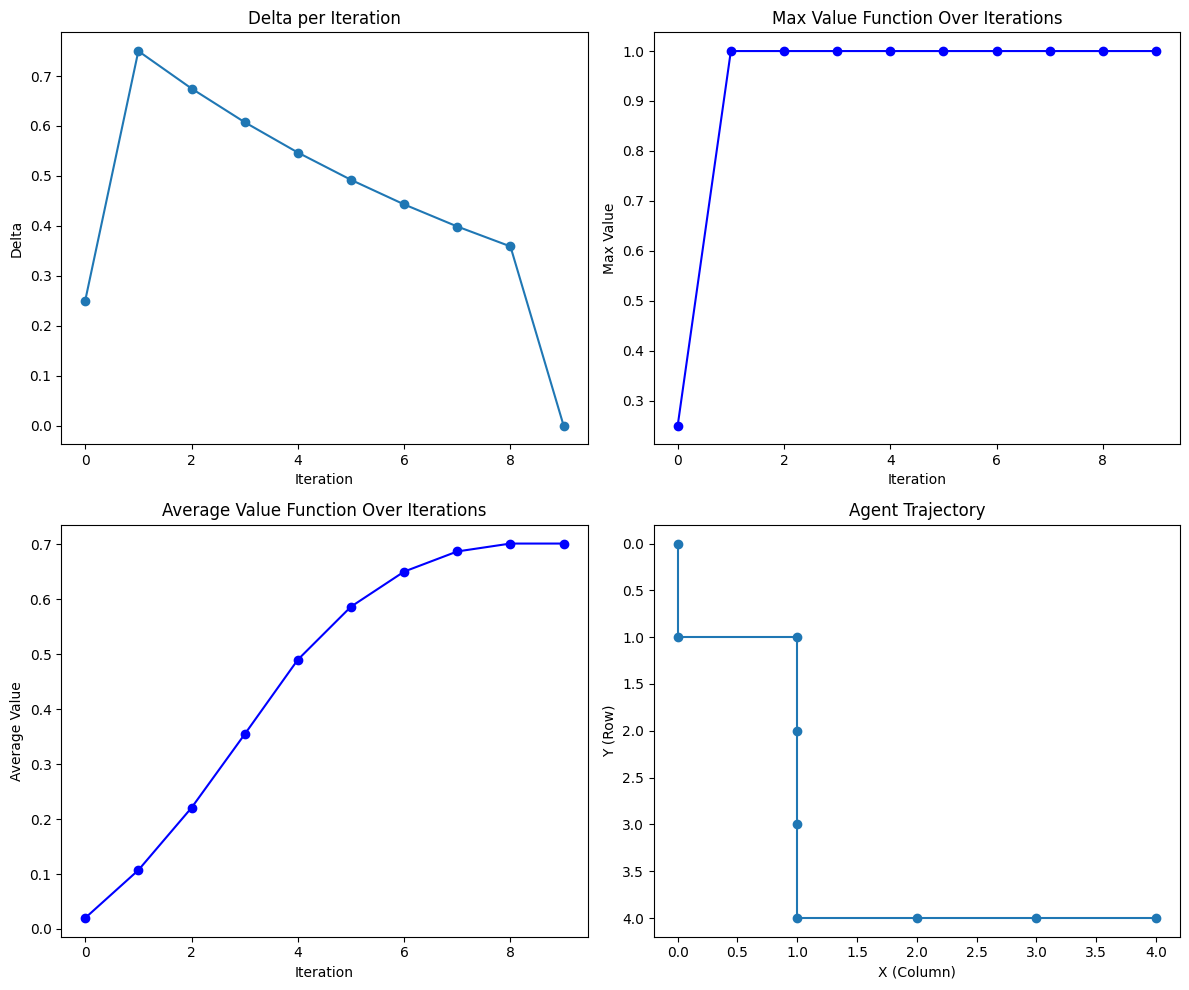

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Iteration에 따른 delta 값 변화
axs[0, 0].plot(delta_history, marker='o')
axs[0, 0].set_title('Delta per Iteration')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Delta')

# 2. Iteration에 따른 전체 가치 함수 최댓값 변화
axs[0, 1].plot(value_max_history, marker='o', color='blue')
axs[0, 1].set_title('Max Value Function Over Iterations')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Max Value')

# 3. Iteration에 따른 전체 가치 함수 평균 변화
axs[1, 0].plot(value_mean_history, marker='o', color='blue')
axs[1, 0].set_title('Average Value Function Over Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Average Value')

# 4. 에이전트 이동 경로 시각화
axs[1, 1].plot(trajectory[:, 1], trajectory[:, 0], marker='o', linestyle='-')
axs[1, 1].set_title('Agent Trajectory')
axs[1, 1].set_xlabel('X (Column)')
axs[1, 1].set_ylabel('Y (Row)')
axs[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()


# 02. 가치 이터레이션
가치 이터레이션은 정책 없이 직접 가치 함수를 최적화하는 방법입니다.
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.
1. value_iteration : 벨만 최적 방정식을 이용해 가치 함수를 반복적으로 업데이트
2. get_value : 현재 상태의 가치를 반환
3. get_action : 현재 가치 함수 기준으로 최적 행동 선택

In [56]:
import numpy as np

class ValueIteration_v:
    def __init__(self, env_v):
        self.env_v = env_v
        self.action_space_v = env_v.action_space
        self.num_actions_v = env_v.num_actions

        # value 2d list 초기화
        self.value_table_v = np.zeros((env_v.height, env_v.width)).tolist()
        self.gamma_v = 0.9  # 할인율

    def value_iteration_v(self):
        next_value_table_v = [
            [0.0 for _v in range(self.env_v.width)]
            for _v in range(self.env_v.height)
        ]
        for x_v in range(self.env_v.height):
            for y_v in range(self.env_v.width):
                state_v = (x_v, y_v)
                if state_v == self.env_v.end_point:
                    # 종료 상태의 가치는 0으로 고정
                    next_value_table_v[x_v][y_v] = 0.0
                    continue

                value_list_v = []
                for action_v in self.action_space_v:
                    action_idx_v = self.action_space_v.index(action_v)
                    next_state_v = self.env_v.state_after_action(state_v, action_idx_v)
                    reward_v = self.env_v.get_reward(state_v, action_idx_v)
                    next_value_v = self.get_value_v(next_state_v)
                    value_list_v.append(reward_v + self.gamma_v * next_value_v)

                # 가능한 모든 행동 중 최대 가치(보상)를 선택
                next_value_table_v[x_v][y_v] = round(max(value_list_v), 2)

        self.value_table_v = next_value_table_v

    def get_action_v(self, state_v):
        # 종료 상태에서는 더 이상 행동이 없으므로 빈 리스트 반환
        if state_v == self.env_v.end_point:
            return []

        action_list_v = []
        max_val_v = -float('inf')
        for action_v in self.action_space_v:
            action_idx_v = self.action_space_v.index(action_v)
            next_state_v = self.env_v.state_after_action(state_v, action_idx_v)
            reward_v = self.env_v.get_reward(state_v, action_idx_v)
            value_v = reward_v + self.gamma_v * self.get_value_v(next_state_v)

            # 최대 가치 갱신
            if value_v > max_val_v:
                max_val_v = value_v
                action_list_v = [action_v]
            elif value_v == max_val_v:
                # 최대 가치가 같은 행동이 여러 개라면 모두 저장
                action_list_v.append(action_v)

        return action_list_v

    def get_value_v(self, state_v):
        # 상태(state_v)의 현재 가치 함수를 반환
        return self.value_table_v[state_v[0]][state_v[1]]


## 가치 이터레이션 실행
정의한 클래스를 이용해 가치 이터레이션을 실행해 주세요.

In [62]:
import matplotlib.pyplot as plt
import numpy as np

if __name__ == '__main__':
    # 환경 생성 (GridWorldEnvironment 클래스는 이미 정의되어 있다고 가정)
    start_point_v = (0, 0)         # 시작점
    end_point_v = (4, 4)           # 목표 지점
    grid_world_size_v = (5, 5)     # 5x5 크기의 격자
    env_v = GridWorldEnvironment(start_point_v, end_point_v, grid_world_size_v)

    # ValueIteration 객체 생성
    vi_v = ValueIteration_v(env_v)

    max_iterations_v = 1000
    theta_v = 1e-8
    iteration_v = 0

    # 시각화용 변수들
    delta_history_v = []
    start_value_history_v = []
    value_max_history_v = []
    value_mean_history_v = []

    while iteration_v < max_iterations_v:
        # 이전 가치 함수 테이블을 복사해 둡니다.
        old_values_v = np.array(vi_v.value_table_v)

        # 가치 함수 업데이트 (Value Iteration)
        vi_v.value_iteration_v()

        # 업데이트된 가치 함수 테이블
        new_values_v = np.array(vi_v.value_table_v)

        # 가치 함수 변화량(delta_v) 계산
        delta_v = np.max(np.abs(new_values_v - old_values_v))
        delta_history_v.append(delta_v)

        # 시작 상태 가치 기록
        start_value_history_v.append(vi_v.get_value_v(env_v.start_point))

        # 전체 상태의 평균/최대 가치 기록
        value_mean_history_v.append(np.mean(new_values_v))
        value_max_history_v.append(np.max(new_values_v))

        print(f"Iteration {iteration_v}: delta = {delta_v:.6f}")

        # 변화량이 임계값(theta_v) 이하이면 수렴으로 판단
        if delta_v < theta_v:
            print(f"Convergence - {iteration_v} iterations")
            break

        iteration_v += 1

    # 최종 가치 함수 출력
    print("\nFinal Value Table:")
    for row_v in vi_v.value_table_v:
        print(" ".join(f"{val_v:6.2f}" for val_v in row_v))

    # 각 상태별 최적 행동(들) 출력
    print("\nOptimal Actions per State:")
    for x_v in range(env_v.height):
        for y_v in range(env_v.width):
            state_v = (x_v, y_v)
            print(f"State {state_v}: {vi_v.get_action_v(state_v)}")

    # 에이전트 경로 시뮬레이션 (trajectory_v)
    trajectory_v = [env_v.start_point]
    current_state_v = env_v.start_point
    max_steps_v = 50  # 무한 루프 방지
    for _v in range(max_steps_v):
        if current_state_v == env_v.end_point:
            break
        actions_v = vi_v.get_action_v(current_state_v)
        if not actions_v:
            break
        # 최적 행동 중 첫 번째 행동 선택
        action_v = actions_v[0]
        current_state_v = env_v.state_after_action(current_state_v, env_v.action_space.index(action_v))
        trajectory_v.append(current_state_v)
    trajectory_v = np.array(trajectory_v)


Iteration 0: delta = 1.000000
Iteration 1: delta = 0.900000
Iteration 2: delta = 0.810000
Iteration 3: delta = 0.730000
Iteration 4: delta = 0.660000
Iteration 5: delta = 0.590000
Iteration 6: delta = 0.530000
Iteration 7: delta = 0.480000
Iteration 8: delta = 0.000000
Convergence - 8 iterations

Final Value Table:
  0.48   0.53   0.59   0.66   0.73
  0.53   0.59   0.66   0.73   0.81
  0.59   0.66   0.73   0.81   0.90
  0.66   0.73   0.81   0.90   1.00
  0.73   0.81   0.90   1.00   0.00

Optimal Actions per State:
State (0, 0): ['down', 'right']
State (0, 1): ['down', 'right']
State (0, 2): ['down', 'right']
State (0, 3): ['down', 'right']
State (0, 4): ['down']
State (1, 0): ['down', 'right']
State (1, 1): ['down', 'right']
State (1, 2): ['down', 'right']
State (1, 3): ['down', 'right']
State (1, 4): ['down']
State (2, 0): ['down', 'right']
State (2, 1): ['down', 'right']
State (2, 2): ['down', 'right']
State (2, 3): ['down', 'right']
State (2, 4): ['down']
State (3, 0): ['down', 'rig

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

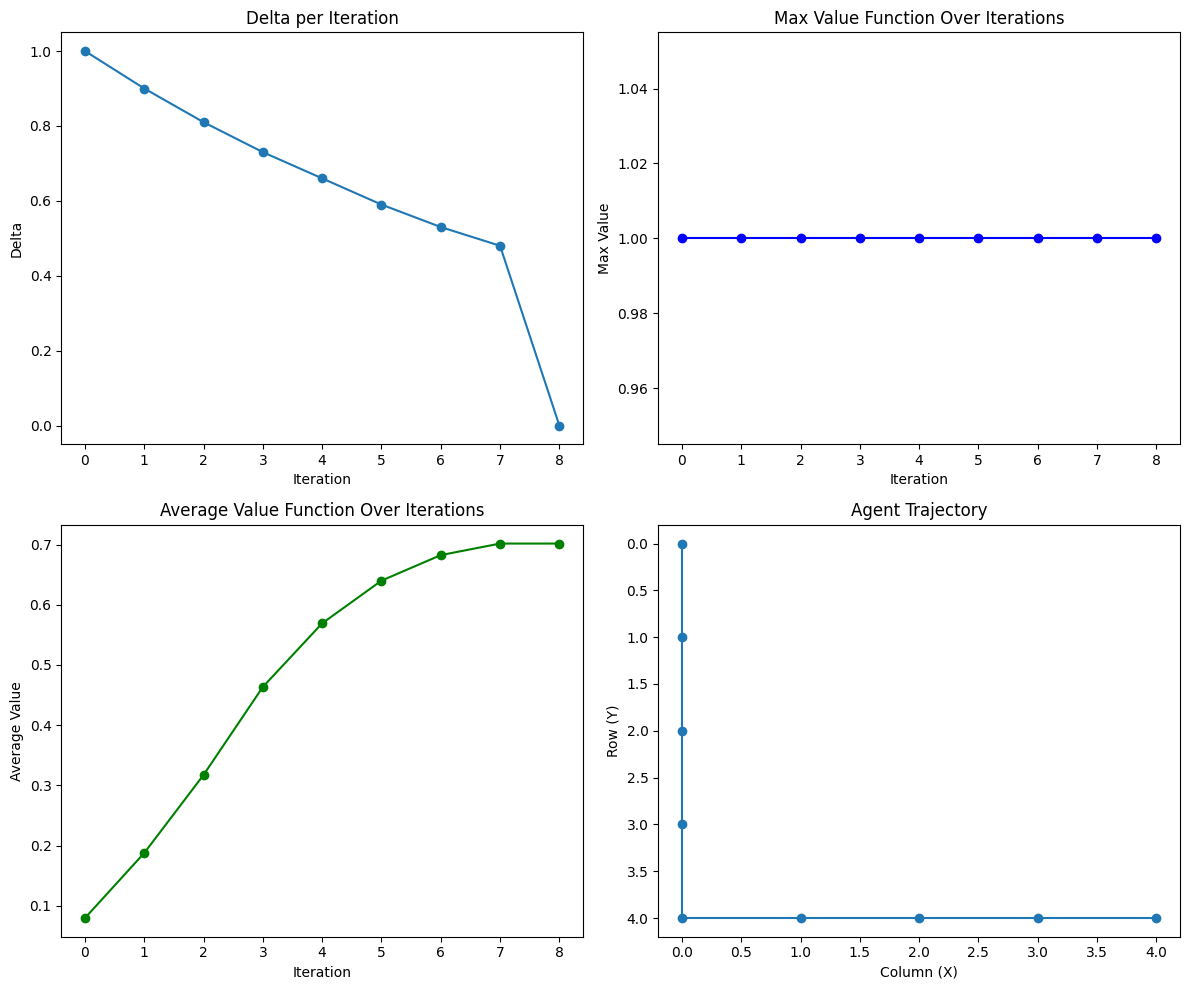

In [64]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Iteration에 따른 delta 값 변화
axs[0, 0].plot(delta_history_v, marker='o')
axs[0, 0].set_title('Delta per Iteration')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Delta')

# 2. Iteration에 따른 전체 가치 함수 최댓값 변화
axs[0, 1].plot(value_max_history_v, marker='o', color='blue')
axs[0, 1].set_title('Max Value Function Over Iterations')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Max Value')

# 3. Iteration에 따른 전체 가치 함수 평균 변화
axs[1, 0].plot(value_mean_history_v, marker='o', color='green')
axs[1, 0].set_title('Average Value Function Over Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Average Value')

# 4. 에이전트 이동 경로 시각화
axs[1, 1].plot(trajectory_v[:, 1], trajectory_v[:, 0], marker='o', linestyle='-')
axs[1, 1].set_title('Agent Trajectory')
axs[1, 1].set_xlabel('Column (X)')
axs[1, 1].set_ylabel('Row (Y)')
axs[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()
